# Conditional GAN using Stanford Dogs Dataset

## Import libraries

In [1]:
import copy
import os
import time
from IPython import display
import xml.etree.ElementTree as ET
import shutil

import cv2
import numpy as np
import pandas as pd
import torch
import dill
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torchinfo import summary
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use("bmh")

/home/ahmadnaufalhakim/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Define constants

In [2]:
DATA_DIR = "./data"
MODEL_DIR = "./models"
OUTPUT_DIR = "./output"
NUM_ALL_FILES = 20580
IMG_SIZE = 128
IMG_CHANNELS = 3
LATENT_DIM = 100
G_EMB_DIM = 32
D_EMB_DIM = 1
BETA1 = .5
BETA2 = .999

EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


## Load dataset

In [3]:
# Make directories if they doesn't exist
if not os.path.exists(os.path.join(DATA_DIR)) :
  os.makedirs(os.path.join(DATA_DIR))
if not os.path.exists(os.path.join(MODEL_DIR)) :
  os.makedirs(os.path.join(MODEL_DIR))
if not os.path.exists(os.path.join(OUTPUT_DIR)) :
  os.makedirs(os.path.join(OUTPUT_DIR))

# Get all the labels
labels_map = {}
for folder in os.listdir(os.path.join(DATA_DIR, "Annotation")) :
  labels_map[folder.split('-')[0]] = folder.split('-')[1]
classes = list(labels_map.values())

# Make a new folder that contains cropped and non-cropped images of dogs
if not os.path.exists(os.path.join(DATA_DIR, "cropped-all-dogs")) :
  os.makedirs(os.path.join(DATA_DIR, "cropped-all-dogs"))
if not os.path.exists(os.path.join(DATA_DIR, "all-dogs")) :
  os.makedirs(os.path.join(DATA_DIR, "all-dogs"))

# Copy all dog images from Images folder to all-dogs folder
if sum([len(files) for r, d, files in os.walk(os.path.join(DATA_DIR, "all-dogs"))]) != NUM_ALL_FILES :
  for folder in os.listdir(os.path.join(DATA_DIR, "Images")) :
    for file in os.listdir(os.path.join(DATA_DIR, "Images", folder)) :
      src = os.path.join(DATA_DIR, "Images", folder, file)
      dst = os.path.join(DATA_DIR, "all-dogs", file)
      if os.path.isfile(src) and not os.path.isfile(dst) :
        shutil.copy(src, dst)

# Iterate through all annotations' bounding box, crop the image, and then save the image back to the created folder
if sum([len(files) for r, d, files in os.walk(os.path.join(DATA_DIR, "cropped-all-dogs"))]) != NUM_ALL_FILES :
  i = 0
  for folder in os.listdir(os.path.join(DATA_DIR, "Annotation")) :
    for file in os.listdir(os.path.join(DATA_DIR, "Annotation", folder)) :
      crop_file = os.path.splitext(file)[0] + "_crop.jpg"
      if not os.path.exists(os.path.join(DATA_DIR, "cropped-all-dogs", crop_file)) :
        xml_tree = ET.parse(os.path.join(DATA_DIR, "Annotation", folder, file))
        root = xml_tree.getroot()
        # get the bounding box coordinates
        xmin = int(root.find('object/bndbox/xmin').text)
        ymin = int(root.find('object/bndbox/ymin').text)
        xmax = int(root.find('object/bndbox/xmax').text)
        ymax = int(root.find('object/bndbox/ymax').text)
        # read the image
        img_path = os.path.join(DATA_DIR, "all-dogs", f"{file}.jpg")
        img = cv2.imread(img_path)
        if img is None :
          print(f"{file}.jpg", type(img))
        # crop the image
        crop = img[ymin:ymax, xmin:xmax]
        # resize the crop to a square
        crop_size = min(crop.shape[:2])
        crop = cv2.resize(crop, (crop_size, crop_size))
        # save the crop to a file
        cv2.imwrite(os.path.join(DATA_DIR, "cropped-all-dogs", crop_file), crop)
        i += 1
else :
  i = NUM_ALL_FILES  

print(f"All {i} dog images have been cropped and saved to {os.path.join(DATA_DIR, 'cropped-all-dogs')}")

All 20580 dog images have been cropped and saved to ./data/cropped-all-dogs


In [4]:
img_paths = []
img_labels = []
for file in os.listdir(os.path.join(DATA_DIR, "cropped-all-dogs")) :
  img_paths.append(os.path.join(DATA_DIR, "cropped-all-dogs", file))
  lbl_k = file.split('_')[0]
  img_labels.append(classes.index(labels_map[lbl_k]))

## Define custom DataLoader and Dataset class

In [5]:
class StanfordDogsDataset(Dataset) :
  def __init__(self, img_paths, img_labels) :
    self.img_paths = img_paths
    self.img_labels = img_labels
    self.transform = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize(mean=(.5,), std=(.5))
    ])
  def __len__(self) :
    return len(self.img_paths)
  def __getitem__(self, index) :
    img = Image.open(self.img_paths[index])
    label = self.img_labels[index]
    img = self.transform(img)
    return img, label

dataset = StanfordDogsDataset(img_paths, img_labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


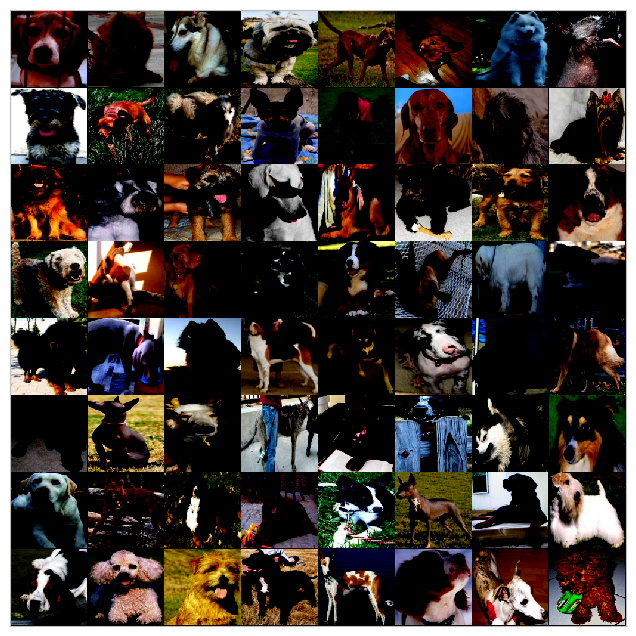

In [6]:
for imgs, labels in dataloader :
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(imgs[:64], nrow=8, padding=1).permute(1,2,0))
  break

## Define the models

In [7]:
# Define custom weights initialization that will be called on both discriminator and generator
def weights_init(model) :
  classname = model.__class__.__name__
  if classname.find("Conv") != -1 :
    torch.nn.init.normal_(model.weight, .0, .02)
  elif classname.find("BatchNorm") != -1 :
    torch.nn.init.normal_(model.weight, 1., .02)
    torch.nn.init.zeros_(model.bias)

### Generator

In [8]:
class Generator(nn.Module) :
  def __init__(self, z_size, img_size, img_channels, n_classes, embedding_dim) :
    super(Generator, self).__init__()

    self.z_size = z_size
    self.img_size = img_size
    self.img_channels = img_channels
    self.n_classes = n_classes
    self.embedding_dim = embedding_dim
    self.label_conditioned_generator = nn.Sequential(
      nn.Embedding(num_embeddings=self.n_classes, embedding_dim=self.embedding_dim),
      nn.Linear(in_features=self.embedding_dim, out_features=16)
    )

    self.latent = nn.Sequential(
      nn.Linear(in_features=self.z_size, out_features=4*4*512),
      nn.LeakyReLU(.2, inplace=True)
    )

    self.model = nn.Sequential(
      nn.ConvTranspose2d(in_channels=513, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(num_features=512),
      nn.ReLU(True),

      nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(num_features=256),
      nn.ReLU(True),

      nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(num_features=128),
      nn.ReLU(True),

      nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(num_features=64),
      nn.ReLU(True),

      nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
      nn.Tanh(),
    )

  def forward(self, inputs) :
    noise_vector, label = inputs
    # print(noise_vector.size(), label.size())
    label_output = self.label_conditioned_generator(label)
    label_output = label_output.view(-1, 1, 4, 4)
    # print(label_output.size())
    latent_output = self.latent(noise_vector)
    latent_output = latent_output.view(-1, 512, 4, 4)
    # print(latent_output.size())
    concat = torch.cat([latent_output, label_output], dim=1)
    # print(concat.size())
    image = self.model(concat)
    return image

# generator = Generator(z_size=LATENT_DIM, img_size=IMG_SIZE, img_channels=IMG_CHANNELS, n_classes=len(classes), embedding_dim=len(classes)).to(DEVICE)
# a = torch.ones(LATENT_DIM)
# b = torch.ones(1)
# b = b.long()
# a = a.to(DEVICE)
# b = b.to(DEVICE)
# c = generator((a,b))
# print(c[0].size())
# print(generator)

# print(a.size(), b.size())
# print(torch.randn(BATCH_SIZE, LATENT_DIM).size())
# print(torch.LongTensor(np.random.randint(0, len(classes), BATCH_SIZE)).size())

# fig, ax = plt.subplots(figsize=(4,4))
# ax.set_xticks([])
# ax.set_yticks([])
# ax.imshow(make_grid(c.detach().cpu(), nrow=8).permute(1,2,0))

### Discriminator

In [9]:
class Discriminator(nn.Module) :
  def __init__(self, img_size, img_channels, n_classes, embedding_dim) :
    super(Discriminator, self).__init__()

    self.img_size = img_size
    self.img_channels = img_channels
    self.n_classes = n_classes
    self.embedding_dim = embedding_dim
    self.label_condition_discriminator = nn.Sequential(
      nn.Embedding(num_embeddings=self.n_classes, embedding_dim=self.embedding_dim),
      nn.Linear(in_features=self.embedding_dim, out_features=self.img_channels*self.img_size*self.img_size)
    )

    self.model = nn.Sequential(
      nn.Conv2d(in_channels=6, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
      nn.LeakyReLU(.2, inplace=True),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=3, padding=2, bias=False),
      nn.BatchNorm2d(num_features=128),
      nn.LeakyReLU(.2, inplace=True),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=3, padding=2, bias=False),
      nn.BatchNorm2d(num_features=256),
      nn.LeakyReLU(.2, inplace=True),

      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=3, padding=2, bias=False),
      nn.BatchNorm2d(num_features=512),
      nn.LeakyReLU(.2, inplace=True),

      nn.Flatten(),
      nn.Dropout(.4),
      nn.Linear(in_features=4608, out_features=1),
      nn.Sigmoid()
    )

  def forward(self, inputs) :
    img, label = inputs
    # print(img.size(), label.size())
    label_output = self.label_condition_discriminator(label)
    label_output = label_output.view(-1, self.img_channels, self.img_size, self.img_size)
    # print(label_output.size())
    concat = torch.cat([img, label_output], dim=1)
    # print(concat.size())
    output = self.model(concat)
    # print(output.size())
    return output

# # DRIVER FOR TESTING PURPOSES
# print(len(classes))
# discriminator = Discriminator(img_size=IMG_SIZE, img_channels=IMG_CHANNELS, n_classes=len(classes), embedding_dim=len(classes)).to(DEVICE)
# a = torch.ones(10,3,128,128)
# b = torch.ones(10,1)
# b = b.long()
# a = a.to(DEVICE)
# b = b.to(DEVICE)
# c = discriminator((a,b))
# print(c)
# print(discriminator)

## Declare models, optimizer, criterion

In [10]:
# Define generator and discriminator models
generator = Generator(
  z_size=LATENT_DIM,
  img_size=IMG_SIZE,
  img_channels=IMG_CHANNELS,
  n_classes=len(classes),
  embedding_dim=G_EMB_DIM
).to(DEVICE)
generator.apply(weights_init)
discriminator = Discriminator(
  img_size=IMG_SIZE,
  img_channels=IMG_CHANNELS,
  n_classes=len(classes),
  embedding_dim=D_EMB_DIM
).to(DEVICE)
discriminator.apply(weights_init)

# Define optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

# Loss function
criterion = nn.BCELoss()

## Define training step script for each generator and discriminator

### Generator

In [11]:
def generator_train_step(batch_size, generator_model, discriminator_model, g_optimizer, criterion, real_labels=None) :
  # Initialize gradients
  g_optimizer.zero_grad()
  # Building latent space (z)
  z = Variable(torch.randn(batch_size, LATENT_DIM)).to(DEVICE)
  # Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, len(classes), batch_size))).to(DEVICE)
  # Generating fake images
  fake_images = generator_model((z, fake_labels))
  # Discriminating fake images using discriminator model
  validity = discriminator_model((fake_images, fake_labels)).squeeze()
  # Calculating discrimination loss (from fake images)
  g_loss = criterion(validity, Variable(torch.ones(validity.size(0))).to(DEVICE))
  # Backward propagation (computing gradient descent)
  g_loss.backward()
  # Update generator model parameters
  g_optimizer.step()
  return g_loss.data

### Discriminator

In [12]:
def discriminator_train_step(batch_size, generator_model, discriminator_model, d_optimizer, criterion, real_images, real_labels) :
  # Initizalize gradients
  d_optimizer.zero_grad()

  # Loss from real images
  ## Discriminating real images
  real_validity = discriminator_model((real_images, real_labels)).squeeze()
  ## Calculating discrimination loss (from real images)
  real_loss = criterion(real_validity, Variable(torch.ones(real_validity.size(0))).to(DEVICE))

  # Loss from fake generated images
  ## Building latent space (z)
  z = Variable(torch.randn(batch_size, LATENT_DIM)).to(DEVICE)
  ## Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, len(classes), batch_size))).to(DEVICE)
  ## Generating fake images
  fake_images = generator_model((z, fake_labels))
  ## Discriminating fake images
  fake_validity = discriminator_model((fake_images, fake_labels)).squeeze()
  ## Calculating discrimination loss (from fake images)
  fake_loss = criterion(fake_validity, Variable(torch.zeros(fake_validity.size(0))).to(DEVICE))

  # Sum two losses (from real and fake images)
  d_loss = real_loss + fake_loss

  # Backward propagation (computing gradient descent)
  d_loss.backward()

  # Update discriminator model parameters
  d_optimizer.step()
  return d_loss.data

## Model training

In [13]:
g_best_loss, d_best_loss = float("inf"), float("inf")
g_best_epoch, d_best_epoch = 0, 0
g_best_model, d_best_model = None, None

elapsed_time = 0
for epoch in range(EPOCHS) :
  g_epoch_losses, d_epoch_losses = [], []
  g_best_epoch_loss, d_best_epoch_loss = float("inf"), float("inf")
  g_best_epoch_batch_itr, d_best_epoch_batch_itr = 0, 0
  g_best_epoch_model, d_best_epoch_model = None, None
  epoch_start_time = time.time()
  display.clear_output(wait=True)
  print(f"Starting training for epoch {epoch+1}/{EPOCHS}")
  # Train discriminator, and then generator for each batch in dataloader
  for i, (images, labels) in enumerate(dataloader) :
    batch_start_time = time.time()
    # Train data
    real_images = Variable(images).to(DEVICE)
    real_labels = Variable(labels).to(DEVICE)
    # Set generator to training mode
    generator.train()
    # Train discriminator
    d_loss = discriminator_train_step(
      batch_size=BATCH_SIZE,
      generator_model=generator,
      discriminator_model=discriminator,
      d_optimizer=d_optimizer,
      criterion=criterion,
      real_images=real_images,
      real_labels=real_labels
    )
    # Train generator
    g_loss = generator_train_step(
      batch_size=BATCH_SIZE,
      generator_model=generator,
      discriminator_model=discriminator,
      g_optimizer=g_optimizer,
      criterion=criterion,
      real_labels=real_labels
    )
    # Record generator and discriminator loss
    g_epoch_losses.append(g_loss.detach().cpu())
    d_epoch_losses.append(d_loss.detach().cpu())
    batch_elapsed_time = time.time() - batch_start_time

    # Save if model has best loss so far (global)
    if g_best_loss >= g_loss :
      g_best_loss = g_loss
      g_best_model = copy.deepcopy(generator.state_dict())
      g_best_epoch = epoch
      g_metadata = {"epoch": epoch+1, "batch_iteration": i+1, "g_loss": g_best_loss}
      with open(os.path.join(MODEL_DIR, "g_best_model.pth"), "wb") as g :
        dill.dump(g_metadata, g)
        torch.save(g_best_model, g)
    if d_best_loss >= d_loss :
      d_best_loss = d_loss
      d_best_model = copy.deepcopy(discriminator.state_dict())
      d_best_epoch = epoch
      d_metadata = {"epoch": epoch+1, "batch_iteration": i+1, "d_loss": d_best_loss}
      with open(os.path.join(MODEL_DIR, "d_best_model.pth"), "wb") as d :
        dill.dump(d_metadata, d)
        torch.save(d_best_model, d)

    # Save if model has best loss (each epoch)
    if g_best_epoch_loss >= g_loss :
      g_best_epoch_loss = g_loss
      g_best_epoch_batch_itr = i
      g_best_epoch_model = copy.deepcopy(generator.state_dict())
    if d_best_epoch_loss >= d_loss :
      d_best_epoch_loss = d_loss
      d_best_epoch_batch_itr = i
      d_best_epoch_model = copy.deepcopy(discriminator.state_dict())

    # Print batch progress
    if (i+1) % 10 == 0 or (i+1) == len(dataloader) :
      current = (i+1) * len(labels) if (i+1) != len(dataloader) else len(dataloader.dataset)
      print(f"### [Batch {i+1}/{len(dataloader)}]\t| g_loss: {g_loss:06f}, d_loss: {d_loss:06f} [{current}/{len(dataloader.dataset)}] ({round(batch_elapsed_time, 3)}s)")

  epoch_elapsed_time = time.time() - epoch_start_time
  elapsed_time += epoch_elapsed_time
  print(f"Epoch {epoch+1} training finished in {round(elapsed_time, 3)} sec(s)")

  # Replace current generator and discriminator with best epoch model
  generator.load_state_dict(g_best_epoch_model)
  discriminator.load_state_dict(d_best_epoch_model)
  # Display image generation in each epoch
  ## Building latent space (z)
  z = Variable(torch.randn(len(classes[:64]), LATENT_DIM)).to(DEVICE)
  ## Building labels
  labels = Variable(torch.LongTensor(np.arange(len(classes[:64])))).to(DEVICE)
  ## Generating images using best epoch model
  sample_images = generator((z, labels)).data.cpu()
  ## Show images
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  grid = make_grid(sample_images, nrow=8, normalize=True).permute(1,2,0).numpy()
  ax.imshow(grid)
  plt.imsave(os.path.join(OUTPUT_DIR, f"epoch_{epoch+1}.png"), grid)
  plt.close()

  # Plot losses
  plt.figure(figsize=(5,5))
  x_range = range(len(g_epoch_losses))
  # Plot losses
  plt.subplot(1,1,1)
  plt.plot(x_range, g_epoch_losses, label=f"Generator Loss")
  plt.plot(x_range, d_epoch_losses, label=f"Discriminator Loss")
  plt.xlabel("Iterations")
  plt.legend(["G","D"])
  plt.title(f"GAN Loss Epoch {epoch+1}")
  # Save the plot
  plt.savefig(os.path.join(OUTPUT_DIR, f"loss_epoch_{epoch+1}.png"))
  plt.close()

  # Save the model each n epoch
  if (epoch+1) % 1 == 0 or (epoch+1) == EPOCHS :
    with open(os.path.join(MODEL_DIR, f"g_best_epoch_model.pth"), "wb") as g :
      dill.dump({"epoch": epoch+1, "batch_iteration": g_best_epoch_batch_itr+1, "g_loss": g_best_epoch_loss}, g)
      torch.save(g_best_epoch_model, g)
    with open(os.path.join(MODEL_DIR, f"d_best_epoch_model.pth"), "wb") as d :
      dill.dump({"epoch": epoch+1, "batch_iteration": d_best_epoch_batch_itr+1, "d_loss": d_best_epoch_loss}, d)
      torch.save(d_best_epoch_model, d)

  # if (i+1) % 5 == 0 or (i+1) == len(dataloader) :
  #   torch.save(generator.state_dict(), os.path.join(MODEL_DIR, f"g_epoch_{epoch+1}.pth"))
  #   torch.save(discriminator.state_dict(), os.path.join(MODEL_DIR, f"d_epoch_{epoch+1}.pth"))
  time.sleep(1)

print(f"Total elapsed time: {round(elapsed_time, 3)} sec(s)")

Starting training for epoch 100/100
### [Batch 10/322]	| g_loss: 2.215117, d_loss: 0.268230 [640/20580] (0.181s)
### [Batch 20/322]	| g_loss: 2.885834, d_loss: 0.090740 [1280/20580] (0.181s)
### [Batch 30/322]	| g_loss: 4.338521, d_loss: 0.263797 [1920/20580] (0.181s)
### [Batch 40/322]	| g_loss: 3.969929, d_loss: 0.392805 [2560/20580] (0.181s)
### [Batch 50/322]	| g_loss: 4.725004, d_loss: 0.249765 [3200/20580] (0.18s)
### [Batch 60/322]	| g_loss: 2.638433, d_loss: 0.644058 [3840/20580] (0.181s)
### [Batch 70/322]	| g_loss: 2.629913, d_loss: 0.381219 [4480/20580] (0.181s)
### [Batch 80/322]	| g_loss: 3.803039, d_loss: 0.945138 [5120/20580] (0.181s)
### [Batch 90/322]	| g_loss: 3.549654, d_loss: 0.222629 [5760/20580] (0.181s)
### [Batch 100/322]	| g_loss: 2.756846, d_loss: 0.341825 [6400/20580] (0.181s)
### [Batch 110/322]	| g_loss: 3.304219, d_loss: 0.276416 [7040/20580] (0.18s)
### [Batch 120/322]	| g_loss: 4.961816, d_loss: 0.391005 [7680/20580] (0.18s)
### [Batch 130/322]	| g_loss: